In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
import random
from torch.serialization import add_safe_globals

In [2]:
def fix_seeds(seed=42, deterministic=True):
    """
    Fix all random seeds for reproducibility.

    Args:
        seed (int): The seed value to use.
        deterministic (bool): If True, forces deterministic behavior in cuDNN (may reduce performance).
    """
    # Python's built-in random module
    random.seed(seed)

    # NumPy random generator
    np.random.seed(seed)

    # PyTorch seed for CPU & CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU

    # Ensuring deterministic behavior (if desired)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # Might slow down training but ensures reproducibility
fix_seeds()

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
class KmeanPINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, convection_velocity=1.0):
        """
        Initialize the Residual-RAE PINN model.
        
        Args:
            input_dim: Dimension of input (typically 1 for 1D convection PDE - time and space)
            output_dim: Dimension of output (typically 1 for scalar solution u)
            hidden_dim: Number of neurons in each hidden layer
            num_layers: Number of hidden layers
        """
        super(KmeanPINN, self).__init__()
        
        # Store parameters
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.convection_velocity = convection_velocity
        
        # Build the neural network
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        """Forward pass of the neural network"""
        return self.network(x)
    
    def compute_pde_residual(self, x, t):
        """
        Compute the residual of the 1D convection PDE: du/dt + a * du/dx = 0
        
        Args:
            x: Spatial coordinates
            t: Time coordinates
            
        Returns:
            PDE residual at points (x,t)
        """
        # Create input tensor
        inputs = torch.cat([x, t], dim=1)
        inputs.requires_grad = True
        
        # Forward pass to get u(x,t)
        u = self(inputs)
        
        grad_u = torch.autograd.grad(
            u,
            inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        u_x = grad_u[:, 0:1]  # derivative with respect to x
        u_t = grad_u[:, 1:2]
        
        # Compute PDE residual: du/dt + a * du/dx = 0
        residual = u_t + self.convection_velocity * u_x
        
        return residual
    
    def compute_ic_residual(self, x, t, u_ic):
        """
        Compute the residual of the initial condition: u(x,0) = u_ic(x)
        
        Args:
            x: Spatial coordinates at t=0
            t: Time coordinates (should be zeros)
            u_ic: Initial condition function
            
        Returns:
            Initial condition residual
        """
        inputs = torch.cat([x, t], dim=1)
        u_pred = self(inputs)
        u_actual = u_ic(x)
        residual = u_pred - u_actual
        return residual
    
    def compute_periodic_bc_residual(self, x_left, x_right, t_bc):
        """
        Compute the residual of the periodic boundary condition: u(x_min, t) = u(x_max, t)
        
        Args:
            x_left: Left boundary spatial coordinates
            x_right: Right boundary spatial coordinates
            t_bc: Time coordinates for boundary points
            
        Returns:
            Periodic boundary condition residual
        """
        # Create input tensors for left and right boundaries
        inputs_left = torch.cat([x_left, t_bc], dim=1)
        inputs_right = torch.cat([x_right, t_bc], dim=1)
        
        # Forward pass to get u at both boundaries
        u_left = self(inputs_left)
        u_right = self(inputs_right)
        
        # Compute residual: u(x_min, t) - u(x_max, t)
        residual = u_left - u_right
        
        return residual

In [5]:
class KMeansPINNSolver:
    def __init__(self, model, n_clusters_r, n_clusters_bc, n_clusters_ic,
        gamma_r=1.0, gamma_bc=1.0, gamma_ic=1.0,
        learning_rate=0.001, beta=0.9, random_state=None,
        w_mean=0.9, w_var=0.4, w_max=0.1):
        """
        Initialize the KMeans-weighted PINN solver.

        Args:
            model: The PINN model (...)
            n_clusters_r: Number of clusters for residual points.
            n_clusters_bc: Number of clusters for boundary condition points.
            n_clusters_ic: Number of clusters for initial condition points.
            gamma_r: Penalty coefficient for residual term.
            gamma_bc: Penalty coefficient for boundary condition term.
            gamma_ic: Penalty coefficient for initial condition term.
            learning_rate: Learning rate for the optimizer.
            beta: Momentum factor for updating cluster weights (0 <= beta < 1).
            random_state: Random state for KMeans for reproducibility.
            w_mean: Weight factor for the mean absolute residual component
            w_var: Weight factor for the variance of absolute residual component
            w_max: Weight factor for the max absolute residual component
        """
        self.model = model.to(device)
        self.n_clusters_r = n_clusters_r
        self.n_clusters_bc = n_clusters_bc
        self.n_clusters_ic = n_clusters_ic
        self.gamma_r = gamma_r
        self.gamma_bc = gamma_bc
        self.gamma_ic = gamma_ic
        self.learning_rate = learning_rate
        self.beta = beta
        self.random_state = random_state
        # Store the statistic weights
        self.w_mean = w_mean
        self.w_var = w_var
        self.w_max = w_max

        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        self.cluster_weights_r = None
        self.cluster_weights_bc = None
        self.cluster_weights_ic = None

        self.labels_r = None
        self.labels_bc = None
        self.labels_ic = None

        # Ensure weights are non-negative
        if not (self.w_mean >= 0 and self.w_var >= 0 and self.w_max >= 0):
            raise ValueError("Statistic weights (w_mean, w_var, w_max) must be non-negative.")
        if self.w_mean + self.w_var + self.w_max <= 0:
             print("Warning: All statistic weights (w_mean, w_var, w_max) are zero. Effective weights will be uniform.")

    def _cluster_points(self, x_r, t_r, t_bc, x_ic, t_ic):
        """Performs KMeans clustering on the input points."""
        # Residual points clustering (spatial + temporal)
        if self.n_clusters_r > 0 and x_r.numel() > 0:
            X_r_np = torch.cat([x_r, t_r], dim=1).detach().cpu().numpy()
            if X_r_np.shape[0] >= self.n_clusters_r:
                kmeans_r = KMeans(n_clusters=self.n_clusters_r, random_state=self.random_state, n_init=10)
                self.labels_r = torch.from_numpy(kmeans_r.fit_predict(X_r_np)).long().to(device)
                self.cluster_weights_r = torch.ones(self.n_clusters_r, device=device) / self.n_clusters_r
            else:
                print(f"Warning: Not enough residual points ({X_r_np.shape[0]}) for {self.n_clusters_r} clusters. Skipping residual clustering.")
                self.n_clusters_r = 0 # Disable clustering for this part

        # Boundary points clustering (temporal only for periodic BC)
        if self.n_clusters_bc > 0 and t_bc.numel() > 0:
            X_bc_np = t_bc.detach().cpu().numpy() # Assuming t_bc determines BC clusters
            if X_bc_np.shape[0] >= self.n_clusters_bc:
                kmeans_bc = KMeans(n_clusters=self.n_clusters_bc, random_state=self.random_state, n_init=10)
                self.labels_bc = torch.from_numpy(kmeans_bc.fit_predict(X_bc_np)).long().to(device)
                self.cluster_weights_bc = torch.ones(self.n_clusters_bc, device=device) / self.n_clusters_bc
            else:
                 print(f"Warning: Not enough BC points ({X_bc_np.shape[0]}) for {self.n_clusters_bc} clusters. Skipping BC clustering.")
                 self.n_clusters_bc = 0 # Disable clustering for this part

        # Initial condition points clustering (spatial + temporal, though t=0)
        if self.n_clusters_ic > 0 and x_ic.numel() > 0:
            X_ic_np = torch.cat([x_ic, t_ic], dim=1).detach().cpu().numpy()
            if X_ic_np.shape[0] >= self.n_clusters_ic:
                kmeans_ic = KMeans(n_clusters=self.n_clusters_ic, random_state=self.random_state, n_init=10)
                self.labels_ic = torch.from_numpy(kmeans_ic.fit_predict(X_ic_np)).long().to(device)
                self.cluster_weights_ic = torch.ones(self.n_clusters_ic, device=device) / self.n_clusters_ic
            else:
                print(f"Warning: Not enough IC points ({X_ic_np.shape[0]}) for {self.n_clusters_ic} clusters. Skipping IC clustering.")
                self.n_clusters_ic = 0 # Disable clustering for this part


    # In class KMeansPINNSolver:

    def _compute_and_update_weights(self, R_r, R_bc, R_ic):
        """
        Computes new cluster weights based on mean, variance, and max
        residuals, normalizes them, and updates using momentum.
        """
        epsilon = 1e-10

        def calculate_combined_weights(n_clusters, labels, R_abs):
            if n_clusters <= 0 or labels is None or R_abs.numel() == 0:
                return None

            means = torch.zeros(n_clusters, device=device)
            variances = torch.zeros(n_clusters, device=device)
            maxima = torch.zeros(n_clusters, device=device)

            for k in range(n_clusters):
                cluster_indices = torch.where(labels == k)[0]
                if len(cluster_indices) > 0:
                    cluster_residuals_abs = R_abs[cluster_indices].detach()
                    means[k] = torch.mean(cluster_residuals_abs)
                    maxima[k] = torch.max(cluster_residuals_abs)
                    # Calculate variance, handle single-point clusters
                    if len(cluster_indices) > 1:
                       variances[k] = torch.var(cluster_residuals_abs, unbiased=False) # Population variance
                    else:
                       variances[k] = 0.0 # Variance is 0 for a single point
                # else: means, variances, maxima remain 0 for empty clusters

            # Normalize each statistic across clusters (sum normalization)
            norm_means = means / (means.sum() + epsilon)
            norm_variances = variances / (variances.sum() + epsilon) # Normalize even if some are 0
            norm_maxima = maxima / (maxima.sum() + epsilon)

            # Combine statistics using weights
            combined_weights = (self.w_mean * norm_means +
                                self.w_var * norm_variances +
                                self.w_max * norm_maxima)

            # Final normalization of combined weights (sum to 1)
            total_combined_weight = combined_weights.sum() + epsilon
            final_weights = combined_weights / total_combined_weight

            return final_weights

        if self.n_clusters_r > 0:
            new_weights_r = calculate_combined_weights(self.n_clusters_r, self.labels_r, torch.abs(R_r))
            if new_weights_r is not None:
                 self.cluster_weights_r = self.beta * new_weights_r + (1 - self.beta) * self.cluster_weights_r

        if self.n_clusters_bc > 0:
            new_weights_bc = calculate_combined_weights(self.n_clusters_bc, self.labels_bc, torch.abs(R_bc))
            if new_weights_bc is not None:
                 self.cluster_weights_bc = self.beta * new_weights_bc + (1 - self.beta) * self.cluster_weights_bc

        if self.n_clusters_ic > 0:
            new_weights_ic = calculate_combined_weights(self.n_clusters_ic, self.labels_ic, torch.abs(R_ic))
            if new_weights_ic is not None:
                self.cluster_weights_ic = self.beta * new_weights_ic + (1 - self.beta) * self.cluster_weights_ic

    def _compute_loss(self, R_r, R_bc, R_ic):
        """Computes the total weighted loss."""
        loss_r = torch.tensor(0.0, device=device)
        if self.n_clusters_r > 0 and self.labels_r is not None:
            point_weights_r = self.cluster_weights_r[self.labels_r]
            loss_r = (point_weights_r * (R_r**2)).sum()
        elif R_r.numel() > 0: # Fallback to uniform weighting if clustering disabled/failed
            loss_r = torch.mean(R_r**2) * R_r.numel() # Keep scale similar

        loss_bc = torch.tensor(0.0, device=device)
        if self.n_clusters_bc > 0 and self.labels_bc is not None:
            point_weights_bc = self.cluster_weights_bc[self.labels_bc]
            loss_bc = (point_weights_bc * (R_bc**2)).sum()
        elif R_bc.numel() > 0:
            loss_bc = torch.mean(R_bc**2) * R_bc.numel()

        loss_ic = torch.tensor(0.0, device=device)
        if self.n_clusters_ic > 0 and self.labels_ic is not None:
            point_weights_ic = self.cluster_weights_ic[self.labels_ic]
            loss_ic = (point_weights_ic * (R_ic**2)).sum()
        elif R_ic.numel() > 0:
            loss_ic = torch.mean(R_ic**2) * R_ic.numel()

        loss = self.gamma_r * loss_r + self.gamma_bc * loss_bc + self.gamma_ic * loss_ic
        return loss, loss_r, loss_bc, loss_ic


    def train(self, x_r, t_r, x_bc_left, x_bc_right, t_bc, x_ic, t_ic, u_ic_fn, epochs=10000,verbose=True):
        """
        Train the KMeans-PINN model with periodic boundary conditions.

        Args:
            x_r, t_r: PDE residual points (tensors on the correct device).
            x_bc_left: Left boundary spatial coordinates (tensor).
            x_bc_right: Right boundary spatial coordinates (tensor).
            t_bc: Time coordinates for boundary points (tensor).
            x_ic, t_ic: Initial condition points (tensors).
            u_ic_fn: Initial condition function (callable).
            epochs: Number of training epochs.
            verbose: Whether to print training progress.

        Returns:
            Trained model and final loss value.
        """
        # Ensure input tensors are on the correct device
        x_r, t_r = x_r.to(device), t_r.to(device)
        x_bc_left, x_bc_right = x_bc_left.to(device), x_bc_right.to(device)
        t_bc = t_bc.to(device)
        x_ic, t_ic = x_ic.to(device), t_ic.to(device)

        # Perform clustering once before training starts
        self._cluster_points(x_r, t_r, t_bc, x_ic, t_ic)

        for epoch in tqdm(range(epochs)):
            self.model.train()

            R_r = self.model.compute_pde_residual(x_r, t_r)
            R_bc = self.model.compute_periodic_bc_residual(x_bc_left, x_bc_right, t_bc)
            R_ic = self.model.compute_ic_residual(x_ic, t_ic, u_ic_fn)

            # Compute cluster weights based on current residuals and update with momentum
            self._compute_and_update_weights(R_r, R_bc, R_ic)

            # Compute the weighted loss
            loss, loss_r_val, loss_bc_val, loss_ic_val = self._compute_loss(R_r, R_bc, R_ic)

            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print progress
            if verbose and epoch % (epochs // 10 if epochs >= 10 else 1) == 0:
                 print(f"Epoch {epoch}: Loss = {loss.item():.6f}, "
                       f"PDE Loss = {loss_r_val.item():.6f}, "
                       f"BC Loss = {loss_bc_val.item():.6f}, "
                       f"IC Loss = {loss_ic_val.item():.6f}")

        self.model.eval()
        return self.model, loss.item()

In [6]:
# Define PDE domain
x_min, x_max = 0.0, 2*np.pi
t_min, t_max = 0.0, 1.0

# Generate training points
n_x, n_t = 50, 50
n_ic = 512
n_bc = 256

x_r = torch.linspace(x_min, x_max, n_x).repeat(n_t, 1).t().reshape(-1, 1).to(device)
t_r = torch.linspace(t_min, t_max, n_t).repeat(n_x).reshape(-1, 1).to(device)

x_ic = torch.linspace(x_min, x_max, n_ic).reshape(-1, 1).to(device)
t_ic = torch.zeros(n_ic, 1).to(device)

x_bc_left = torch.full((n_bc, 1), x_min).to(device)
x_bc_right = torch.full((n_bc, 1), x_max).to(device)
t_bc = torch.linspace(t_min, t_max, n_bc).reshape(-1, 1).to(device)

def u_ic_fn(x):
    return torch.sin(x)

# Create model and solver
input_dim = 2  # (x, t)
output_dim = 1  # u(x,t)
hidden_dim = 50
num_layers = 4
convection_velocity = 70.0

# Hyperparameters from the algorithm
gamma_r = 1.0   # penalty coefficient for residual
gamma_bc = 40.0  # penalty coefficient for boundary
gamma_ic = 10.0  # penalty coefficient for initial condition
learning_rate = 1e-3


In [7]:
def exact_solution_fft(x_array, t, h_values, beta, x_max):
    """
    Computes the exact solution of the 1D convection PDE using the Fourier transform approach.
    Assumes periodic boundary conditions on [0, x_max).

    Args:
        x_array (np.ndarray): 1D array of x-values (length N) on [0, x_max), evenly spaced.
        t (float): Time at which to evaluate the solution.
        h_values (np.ndarray): 1D array of h(x_array), same length as x_array.
        beta (float): Convection speed.
        x_max (float): Domain length for periodic boundary conditions.

    Returns:
        np.ndarray: Real part of the exact solution u(x, t) on the same grid x_array.
    """
    N = len(x_array)
    # Forward FFT of initial condition
    H_k = np.fft.fft(h_values)
    # Wavenumbers k: 2π * (integer) / x_max
    k_array = 2 * np.pi * np.fft.fftfreq(N, d=(x_max / N))
    # Multiply by e^{- i * beta * k * t}
    phase_factor = np.exp(-1j * beta * k_array * t)
    U_k = H_k * phase_factor
    # Inverse FFT to get solution
    u_vals = np.fft.ifft(U_k)
    return u_vals.real

In [8]:
add_safe_globals([KmeanPINN])
def visualize(model):
    model.eval()
    Nx = 256
    Nt = 100
    x_vals = np.linspace(0, x_max, Nx, endpoint=False)
    t_vals = np.linspace(0, t_max, Nt)
    X, T = np.meshgrid(x_vals, t_vals)
    h_values = np.sin(x_vals)
    U_exact = np.zeros_like(X)
    for i, t_val in enumerate(t_vals):
        U_exact[i, :] = exact_solution_fft(x_vals, t_val, h_values, convection_velocity, x_max)
    XT = np.stack([X.ravel(), T.ravel()], axis=1)
    XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)
    with torch.no_grad():
        U_pred_tensor = model(XT_tensor)
    U_pred = U_pred_tensor.cpu().numpy().reshape(Nt, Nx)
    U_diff = U_pred - U_exact
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # (a) Exact solution
    c1 = axes[0].imshow(
    U_exact.T,
    extent=[0, t_max, 0, x_max],  # x horizontal, t vertical
    origin="lower",
    aspect="auto",
    cmap="rainbow"
    )
    axes[0].set_title(f"(a) Exact solution for β={convection_velocity}")
    axes[0].set_xlabel("t")
    axes[0].set_ylabel("x")
    fig.colorbar(c1, ax=axes[0])

    # (b) PINN solution
    c2 = axes[1].imshow(
        U_pred.T,
        extent=[0, t_max, 0, x_max],
        origin="lower",
        aspect='auto',
        cmap='rainbow'
    )
    axes[1].set_title(f"(b) PINN solution for β={convection_velocity}")
    axes[1].set_xlabel("t")
    axes[1].set_ylabel("x")
    fig.colorbar(c2, ax=axes[1])

    # (c) Difference
    c3 = axes[2].imshow(
        U_diff.T,
        extent=[0, t_max, 0, x_max],
        origin="lower",
        aspect='auto',
        cmap='gray'
    )
    axes[2].set_title(f"(c) Difference (PINN - Exact) for β={convection_velocity}")
    axes[2].set_xlabel("t")
    axes[2].set_ylabel("x")
    fig.colorbar(c3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    MAE = np.mean(np.abs(U_diff))
    print("Mean Absolute error: ", MAE)


FOR CLUSTERS: 20


  0%|          | 0/200000 [00:00<?, ?it/s]/home/vyom/Desktop/MLNS/env/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 10/200000 [00:00<1:36:31, 34.53it/s]

Epoch 0: Loss = 410352.562500, PDE Loss = 340574.875000, BC Loss = 30.033829, IC Loss = 6857.635254


 10%|█         | 20013/200000 [03:02<27:26, 109.35it/s]

Epoch 20000: Loss = 4316.053711, PDE Loss = 33.798859, BC Loss = 91.030724, IC Loss = 64.102577


 20%|██        | 40011/200000 [06:17<25:38, 104.01it/s]

Epoch 40000: Loss = 3033.790527, PDE Loss = 23.269783, BC Loss = 68.496864, IC Loss = 27.064625


 30%|███       | 60016/200000 [09:32<22:48, 102.27it/s]

Epoch 60000: Loss = 3040.134277, PDE Loss = 86.136993, BC Loss = 63.235703, IC Loss = 42.456909


 40%|████      | 80012/200000 [12:46<19:38, 101.79it/s]

Epoch 80000: Loss = 2233.190674, PDE Loss = 18.179268, BC Loss = 50.620338, IC Loss = 19.019798


 50%|█████     | 100019/200000 [16:01<15:38, 106.58it/s]

Epoch 100000: Loss = 1802.640137, PDE Loss = 12.816398, BC Loss = 42.137421, IC Loss = 10.432684


 60%|██████    | 120020/200000 [19:16<12:40, 105.21it/s]

Epoch 120000: Loss = 1498.039673, PDE Loss = 9.414642, BC Loss = 35.984024, IC Loss = 4.926402


 70%|███████   | 140013/200000 [22:35<10:16, 97.28it/s] 

Epoch 140000: Loss = 1426.537964, PDE Loss = 8.012864, BC Loss = 34.093498, IC Loss = 5.478518


 80%|████████  | 160012/200000 [26:08<07:09, 93.09it/s] 

Epoch 160000: Loss = 1195.419067, PDE Loss = 8.533546, BC Loss = 28.784565, IC Loss = 3.550297


 90%|█████████ | 180012/200000 [29:41<03:50, 86.76it/s] 

Epoch 180000: Loss = 1141.063477, PDE Loss = 7.764400, BC Loss = 27.482937, IC Loss = 3.398155


100%|██████████| 200000/200000 [33:05<00:00, 100.71it/s]


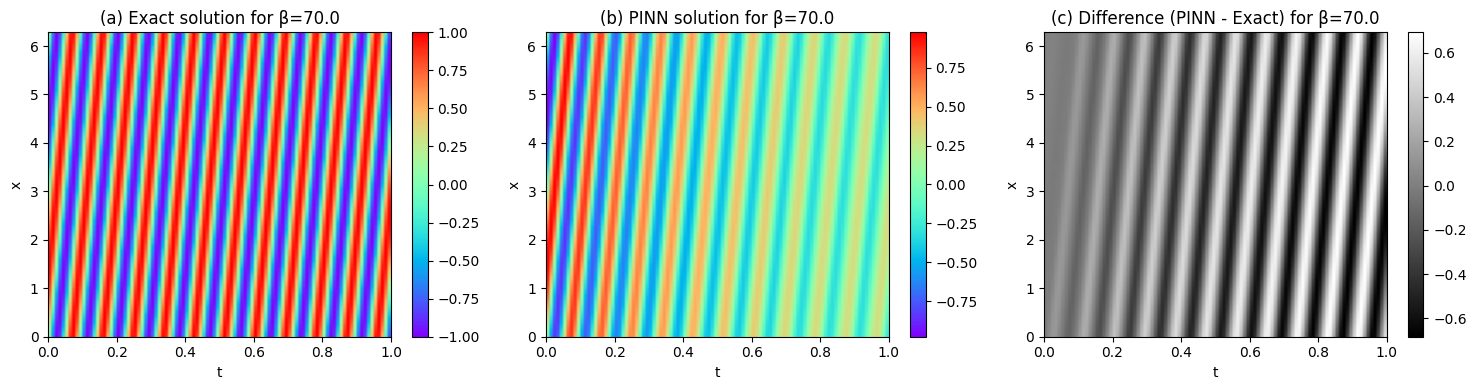

Mean Absolute error:  0.2936236377736985
FOR CLUSTERS: 50


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 493554.000000, PDE Loss = 417356.656250, BC Loss = 112.044189, IC Loss = 7171.555176


 10%|█         | 20011/200000 [04:19<38:18, 78.32it/s] 

Epoch 20000: Loss = 3543.496094, PDE Loss = 1247.368652, BC Loss = 53.484787, IC Loss = 15.673588


 20%|██        | 40011/200000 [08:32<33:42, 79.10it/s]

Epoch 40000: Loss = 2581.545898, PDE Loss = 874.245972, BC Loss = 39.596687, IC Loss = 12.343256


 30%|███       | 60009/200000 [12:46<29:18, 79.60it/s]

Epoch 60000: Loss = 1423.246948, PDE Loss = 132.939758, BC Loss = 30.818403, IC Loss = 5.757119


 40%|████      | 80015/200000 [16:47<24:41, 81.00it/s]

Epoch 80000: Loss = 1046.239502, PDE Loss = 127.624550, BC Loss = 22.109077, IC Loss = 3.425182


 50%|█████     | 100010/200000 [20:43<19:16, 86.49it/s]

Epoch 100000: Loss = 1020.227234, PDE Loss = 427.401276, BC Loss = 14.000044, IC Loss = 3.282415


 60%|██████    | 120015/200000 [24:33<16:33, 80.55it/s]

Epoch 120000: Loss = 474.647949, PDE Loss = 18.041782, BC Loss = 10.959041, IC Loss = 1.824455


 70%|███████   | 140013/200000 [28:40<12:34, 79.47it/s]

Epoch 140000: Loss = 470.655304, PDE Loss = 12.790866, BC Loss = 10.991323, IC Loss = 1.821154


 80%|████████  | 160013/200000 [32:52<07:57, 83.71it/s]

Epoch 160000: Loss = 314.056702, PDE Loss = 5.809797, BC Loss = 7.421038, IC Loss = 1.140541


 90%|█████████ | 180014/200000 [37:05<04:14, 78.58it/s]

Epoch 180000: Loss = 239.554688, PDE Loss = 5.260446, BC Loss = 5.651884, IC Loss = 0.821888


100%|██████████| 200000/200000 [41:18<00:00, 80.68it/s]


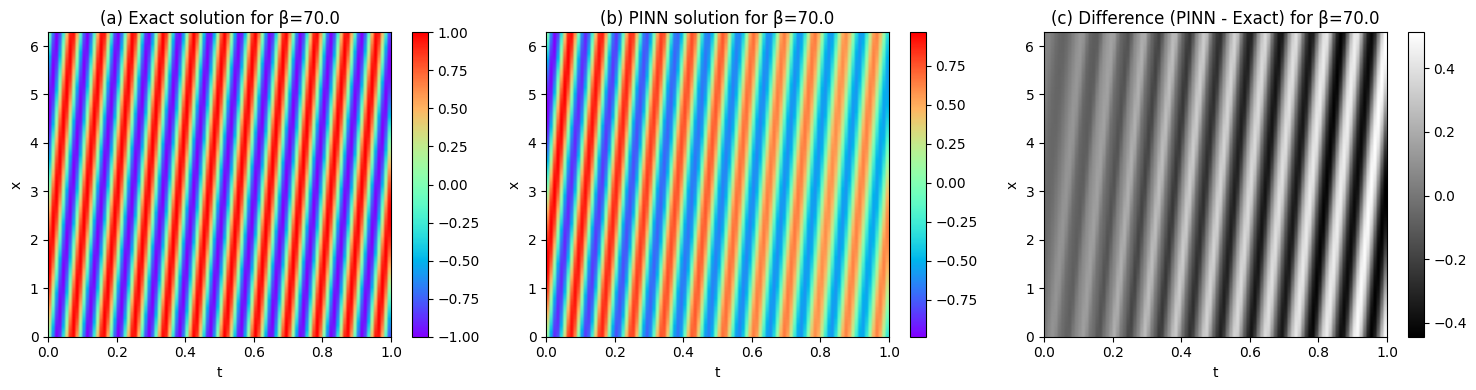

Mean Absolute error:  0.18278159816392112


In [9]:
n_clusters_r = [20 ,50]
n_clusters_bc = 10
n_clusters_ic = 20
w_mean=0.9
w_var=0.4
w_max=0.1
for clusters in n_clusters_r:
    print(f"FOR CLUSTERS: {clusters}")
    model = KmeanPINN(input_dim,output_dim,hidden_dim,num_layers,convection_velocity).to(device)
    solver = KMeansPINNSolver(model,clusters,n_clusters_bc,n_clusters_ic,gamma_r, gamma_bc, gamma_ic, learning_rate, w_mean = w_mean, w_max = w_max,w_var = w_var)
    model,final_loss = solver.train(
        x_r, t_r, 
        x_bc_left, x_bc_right, t_bc, 
        x_ic, t_ic, 
        u_ic_fn, 
        epochs=200000
    )
    visualize(model)
    del model, solver
    torch.cuda.empty_cache()

FOR CLUSTERS: 200


  0%|          | 4/200000 [00:00<1:44:36, 31.87it/s]

Epoch 0: Loss = 106425.234375, PDE Loss = 34555.164062, BC Loss = 6.347327, IC Loss = 7161.617188


 10%|█         | 20006/200000 [09:14<1:23:44, 35.82it/s]

Epoch 20000: Loss = 2528.006836, PDE Loss = 866.882996, BC Loss = 37.915234, IC Loss = 14.451448


 20%|██        | 40006/200000 [18:19<1:14:04, 36.00it/s]

Epoch 40000: Loss = 1686.138550, PDE Loss = 182.185120, BC Loss = 36.438187, IC Loss = 4.642593


 30%|███       | 60006/200000 [27:26<1:04:13, 36.33it/s]

Epoch 60000: Loss = 1704.224609, PDE Loss = 414.869324, BC Loss = 29.970638, IC Loss = 9.052973


 40%|████      | 80005/200000 [36:38<55:12, 36.23it/s]  

Epoch 80000: Loss = 755.343506, PDE Loss = 69.606750, BC Loss = 16.548458, IC Loss = 2.379839


 50%|█████     | 100005/200000 [45:47<44:56, 37.08it/s]

Epoch 100000: Loss = 545.728943, PDE Loss = 45.054642, BC Loss = 12.213926, IC Loss = 1.211725


 60%|██████    | 120006/200000 [55:01<36:18, 36.72it/s]

Epoch 120000: Loss = 296.705994, PDE Loss = 120.634361, BC Loss = 4.102244, IC Loss = 1.198187


 70%|███████   | 140006/200000 [1:04:09<27:27, 36.41it/s]

Epoch 140000: Loss = 55.652290, PDE Loss = 6.310029, BC Loss = 1.185002, IC Loss = 0.194217


 80%|████████  | 160005/200000 [1:13:21<18:30, 36.03it/s]

Epoch 160000: Loss = 44.782829, PDE Loss = 7.511591, BC Loss = 0.882890, IC Loss = 0.195564


 90%|█████████ | 180006/200000 [1:22:31<09:18, 35.81it/s]

Epoch 180000: Loss = 27.852755, PDE Loss = 2.249047, BC Loss = 0.611527, IC Loss = 0.114261


100%|██████████| 200000/200000 [1:31:38<00:00, 36.38it/s]


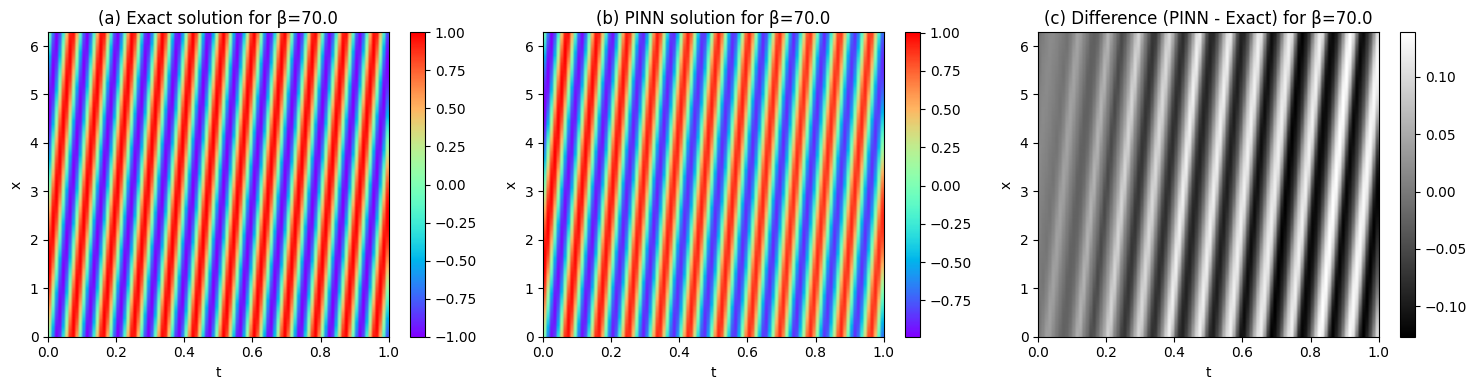

Mean Absolute error:  0.05791070572241853


In [11]:
n_clusters_r = [200]
n_clusters_bc = 10
n_clusters_ic = 20
w_mean=0.9
w_var=0.4
w_max=0.1
for clusters in n_clusters_r:
    print(f"FOR CLUSTERS: {clusters}")
    model = KmeanPINN(input_dim,output_dim,hidden_dim,num_layers,convection_velocity).to(device)
    solver = KMeansPINNSolver(model,clusters,n_clusters_bc,n_clusters_ic,gamma_r, gamma_bc, gamma_ic, learning_rate, w_mean = w_mean, w_max = w_max,w_var = w_var)
    model,final_loss = solver.train(
        x_r, t_r, 
        x_bc_left, x_bc_right, t_bc, 
        x_ic, t_ic, 
        u_ic_fn, 
        epochs=200000
    )
    visualize(model)
    del model, solver
    torch.cuda.empty_cache()

FOR W_MEAN: 0.3, W_VAR:0.3, W_MAX:0.3


  0%|          | 16/200000 [00:00<42:24, 78.59it/s]

Epoch 0: Loss = 164298.250000, PDE Loss = 97596.218750, BC Loss = 13.773561, IC Loss = 6615.109375


 10%|█         | 20017/200000 [04:08<36:13, 82.82it/s]

Epoch 20000: Loss = 2355.927490, PDE Loss = 40.876778, BC Loss = 55.148186, IC Loss = 10.912321


 20%|██        | 40012/200000 [07:52<30:17, 88.03it/s]

Epoch 40000: Loss = 1688.378906, PDE Loss = 29.176168, BC Loss = 39.118187, IC Loss = 9.447519


 30%|███       | 60014/200000 [11:49<27:55, 83.54it/s]

Epoch 60000: Loss = 1084.759277, PDE Loss = 35.401573, BC Loss = 24.417946, IC Loss = 7.263992


 40%|████      | 80016/200000 [15:59<27:13, 73.44it/s]

Epoch 80000: Loss = 602.107300, PDE Loss = 12.376373, BC Loss = 14.173237, IC Loss = 2.280153


 50%|█████     | 100010/200000 [20:09<20:48, 80.12it/s]

Epoch 100000: Loss = 436.073578, PDE Loss = 9.179627, BC Loss = 10.298305, IC Loss = 1.496176


 60%|██████    | 120009/200000 [24:16<15:58, 83.43it/s]

Epoch 120000: Loss = 364.036499, PDE Loss = 10.405058, BC Loss = 8.454538, IC Loss = 1.544993


 70%|███████   | 140007/200000 [28:24<14:01, 71.33it/s]

Epoch 140000: Loss = 631.268311, PDE Loss = 279.443726, BC Loss = 7.527699, IC Loss = 5.071659


 80%|████████  | 160009/200000 [32:35<08:11, 81.33it/s]

Epoch 160000: Loss = 190.025101, PDE Loss = 3.939400, BC Loss = 4.493331, IC Loss = 0.635244


 90%|█████████ | 180012/200000 [36:43<04:09, 80.22it/s]

Epoch 180000: Loss = 156.584305, PDE Loss = 3.254962, BC Loss = 3.698864, IC Loss = 0.537480


100%|██████████| 200000/200000 [41:04<00:00, 81.15it/s]


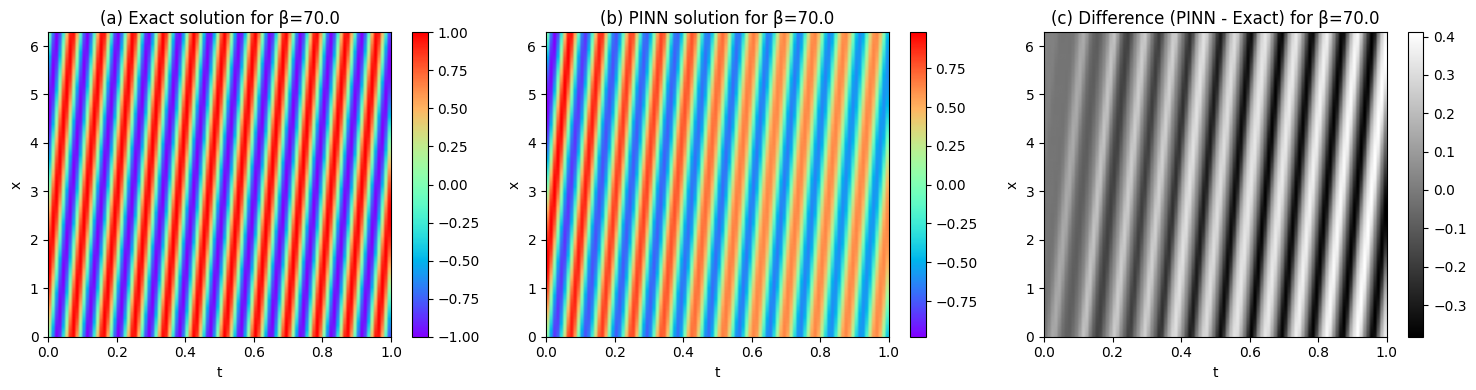

Mean Absolute error:  0.1702373017668139
FOR W_MEAN: 0.3, W_VAR:0.3, W_MAX:0.9


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 1070058.375000, PDE Loss = 989962.875000, BC Loss = 164.997406, IC Loss = 7349.562012


 10%|█         | 20010/200000 [04:14<37:54, 79.15it/s]

Epoch 20000: Loss = 2240.312012, PDE Loss = 45.352470, BC Loss = 51.976357, IC Loss = 11.590528


 20%|██        | 40017/200000 [08:32<30:09, 88.40it/s]

Epoch 40000: Loss = 1828.975098, PDE Loss = 113.539436, BC Loss = 40.379395, IC Loss = 10.025986


 30%|███       | 60012/200000 [12:59<29:09, 80.03it/s]

Epoch 60000: Loss = 1692.049683, PDE Loss = 389.606232, BC Loss = 30.706215, IC Loss = 7.419499


 40%|████      | 80016/200000 [17:29<25:34, 78.20it/s]

Epoch 80000: Loss = 1211.617310, PDE Loss = 36.491936, BC Loss = 28.423199, IC Loss = 3.819739


 50%|█████     | 100010/200000 [21:45<21:26, 77.71it/s]

Epoch 100000: Loss = 655.588379, PDE Loss = 23.373337, BC Loss = 15.265537, IC Loss = 2.159354


 60%|██████    | 120017/200000 [26:05<17:59, 74.10it/s]

Epoch 120000: Loss = 426.799774, PDE Loss = 11.737596, BC Loss = 9.957954, IC Loss = 1.674398


 70%|███████   | 140013/200000 [30:21<13:00, 76.88it/s]

Epoch 140000: Loss = 280.930603, PDE Loss = 7.475096, BC Loss = 6.599307, IC Loss = 0.948324


 80%|████████  | 160009/200000 [34:36<08:36, 77.47it/s]

Epoch 160000: Loss = 246.928345, PDE Loss = 5.103021, BC Loss = 5.819429, IC Loss = 0.904813


 90%|█████████ | 180010/200000 [38:51<04:16, 77.99it/s]

Epoch 180000: Loss = 183.742416, PDE Loss = 16.169397, BC Loss = 4.039478, IC Loss = 0.599388


100%|██████████| 200000/200000 [43:05<00:00, 77.36it/s]


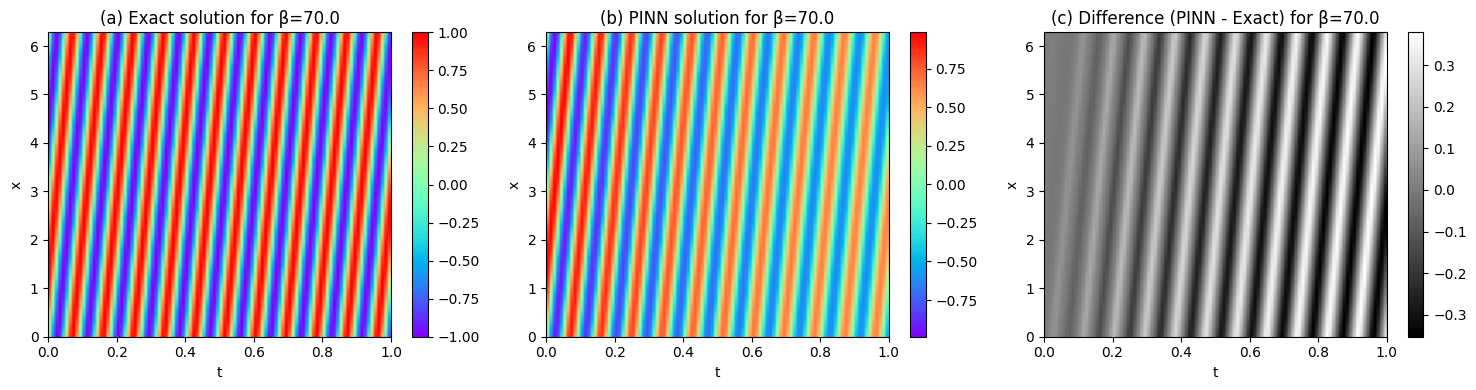

Mean Absolute error:  0.1420524540125312
FOR W_MEAN: 0.3, W_VAR:0.9, W_MAX:0.3


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 838522.250000, PDE Loss = 769196.562500, BC Loss = 159.481354, IC Loss = 6294.643555


 10%|█         | 20008/200000 [04:14<38:29, 77.94it/s]

Epoch 20000: Loss = 2757.161377, PDE Loss = 34.163887, BC Loss = 62.315353, IC Loss = 23.038330


 20%|██        | 40011/200000 [08:28<33:41, 79.14it/s]

Epoch 40000: Loss = 2088.663818, PDE Loss = 168.627625, BC Loss = 44.673111, IC Loss = 13.311178


 30%|███       | 60017/200000 [12:42<28:58, 80.53it/s]

Epoch 60000: Loss = 1626.142456, PDE Loss = 51.947487, BC Loss = 36.167732, IC Loss = 12.748573


 40%|████      | 80016/200000 [16:56<25:00, 79.98it/s]

Epoch 80000: Loss = 1421.754150, PDE Loss = 60.176620, BC Loss = 32.250130, IC Loss = 7.157237


 50%|█████     | 100013/200000 [21:11<21:17, 78.29it/s]

Epoch 100000: Loss = 1230.795532, PDE Loss = 18.067181, BC Loss = 29.528551, IC Loss = 3.158631


 60%|██████    | 120013/200000 [25:25<16:37, 80.18it/s]

Epoch 120000: Loss = 1044.741089, PDE Loss = 16.548002, BC Loss = 25.080809, IC Loss = 2.496076


 70%|███████   | 140013/200000 [29:43<12:51, 77.71it/s]

Epoch 140000: Loss = 1140.016479, PDE Loss = 240.464172, BC Loss = 20.292034, IC Loss = 8.787092


 80%|████████  | 160013/200000 [33:58<07:59, 83.46it/s]

Epoch 160000: Loss = 319.889404, PDE Loss = 6.232928, BC Loss = 7.547195, IC Loss = 1.176864


 90%|█████████ | 180016/200000 [38:09<04:01, 82.84it/s]

Epoch 180000: Loss = 221.790298, PDE Loss = 8.927542, BC Loss = 5.160034, IC Loss = 0.646140


100%|██████████| 200000/200000 [42:18<00:00, 78.77it/s]


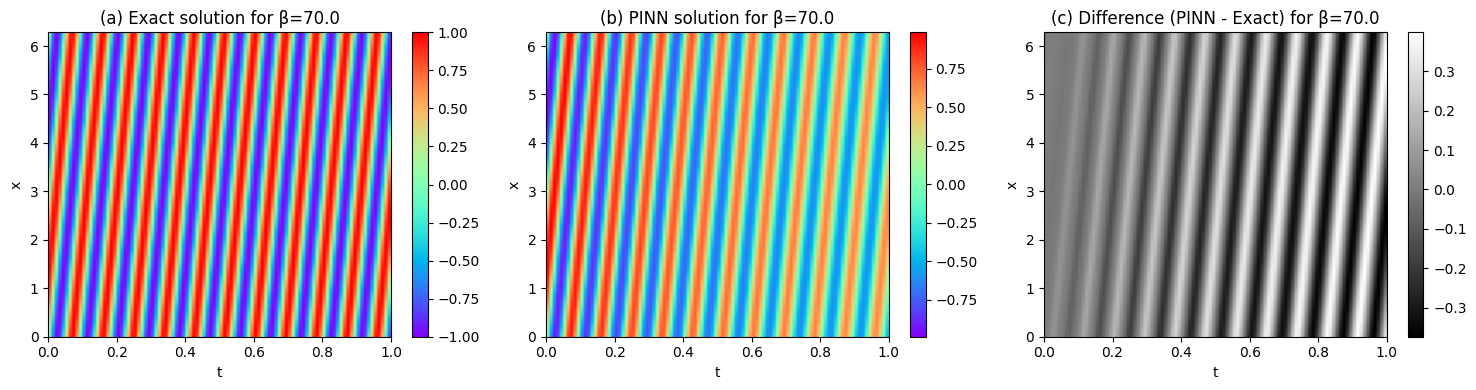

Mean Absolute error:  0.15142663628986663
FOR W_MEAN: 0.3, W_VAR:0.9, W_MAX:0.9


  0%|          | 8/200000 [00:00<45:06, 73.90it/s]

Epoch 0: Loss = 659117.187500, PDE Loss = 592702.875000, BC Loss = 145.476303, IC Loss = 6059.523438


 10%|█         | 20014/200000 [04:21<38:03, 78.83it/s]

Epoch 20000: Loss = 2322.937988, PDE Loss = 40.644817, BC Loss = 54.289948, IC Loss = 11.069538


 20%|██        | 40012/200000 [08:37<31:24, 84.88it/s]

Epoch 40000: Loss = 1455.898193, PDE Loss = 38.806759, BC Loss = 34.360004, IC Loss = 4.269132


 30%|███       | 60016/200000 [12:49<28:32, 81.73it/s]

Epoch 60000: Loss = 1253.954834, PDE Loss = 22.930794, BC Loss = 29.873415, IC Loss = 3.608742


 40%|████      | 80015/200000 [17:08<23:54, 83.64it/s]

Epoch 80000: Loss = 1160.035278, PDE Loss = 23.190802, BC Loss = 27.512558, IC Loss = 3.634218


 50%|█████     | 100014/200000 [21:17<21:36, 77.13it/s]

Epoch 100000: Loss = 1035.923584, PDE Loss = 18.347437, BC Loss = 24.701378, IC Loss = 2.952104


 60%|██████    | 120018/200000 [25:52<15:27, 86.21it/s]

Epoch 120000: Loss = 455.248138, PDE Loss = 11.621668, BC Loss = 10.775940, IC Loss = 1.258886


 70%|███████   | 140011/200000 [29:58<14:00, 71.37it/s]

Epoch 140000: Loss = 318.058868, PDE Loss = 6.772532, BC Loss = 7.538318, IC Loss = 0.975364


 80%|████████  | 160012/200000 [34:39<09:16, 71.85it/s]

Epoch 160000: Loss = 254.911667, PDE Loss = 5.424119, BC Loss = 6.042712, IC Loss = 0.777906


 90%|█████████ | 180013/200000 [39:17<04:58, 67.05it/s]

Epoch 180000: Loss = 460.990967, PDE Loss = 141.881866, BC Loss = 7.625577, IC Loss = 1.408604


100%|██████████| 200000/200000 [43:46<00:00, 76.16it/s]


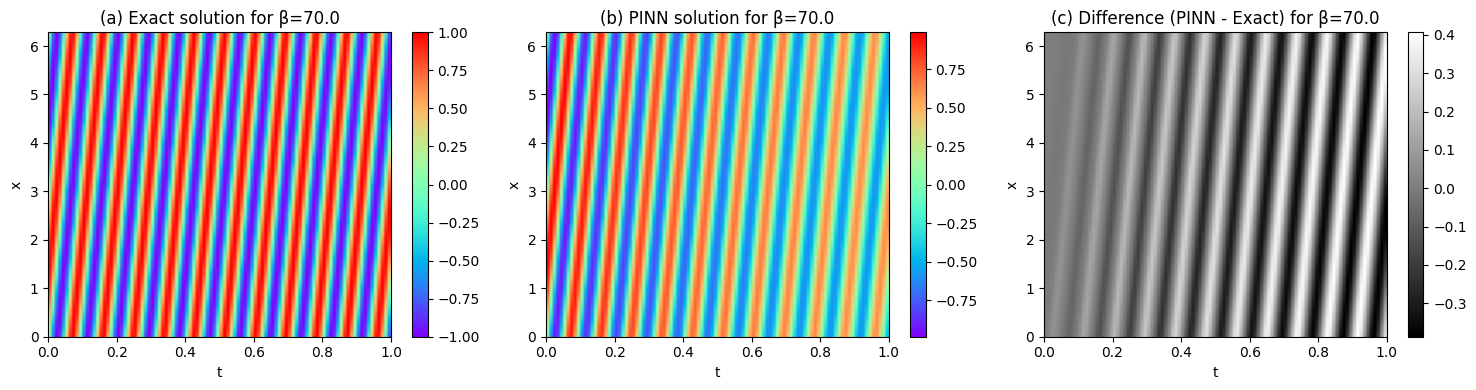

Mean Absolute error:  0.15446187919494586
FOR W_MEAN: 0.9, W_VAR:0.3, W_MAX:0.3


  0%|          | 15/200000 [00:00<46:33, 71.58it/s]

Epoch 0: Loss = 253216.093750, PDE Loss = 187314.578125, BC Loss = 13.873564, IC Loss = 6534.657227


 10%|█         | 20010/200000 [04:23<40:35, 73.91it/s]

Epoch 20000: Loss = 2175.307373, PDE Loss = 32.865292, BC Loss = 50.897190, IC Loss = 10.655456


 20%|██        | 40016/200000 [08:43<34:04, 78.26it/s]

Epoch 40000: Loss = 1609.428101, PDE Loss = 107.222649, BC Loss = 35.685722, IC Loss = 7.477646


 30%|███       | 60011/200000 [13:08<30:53, 75.51it/s]

Epoch 60000: Loss = 1244.283203, PDE Loss = 47.797493, BC Loss = 29.278723, IC Loss = 2.533675


 40%|████      | 80011/200000 [17:31<29:52, 66.93it/s]

Epoch 80000: Loss = 810.552551, PDE Loss = 17.226986, BC Loss = 19.252705, IC Loss = 2.321741


 50%|█████     | 100015/200000 [21:53<22:09, 75.19it/s]

Epoch 100000: Loss = 459.544617, PDE Loss = 10.466661, BC Loss = 10.932598, IC Loss = 1.177400


 60%|██████    | 120016/200000 [26:19<17:59, 74.10it/s]

Epoch 120000: Loss = 468.532593, PDE Loss = 165.238464, BC Loss = 6.955187, IC Loss = 2.508663


 70%|███████   | 140008/200000 [30:42<13:22, 74.73it/s]

Epoch 140000: Loss = 275.405548, PDE Loss = 73.556244, BC Loss = 4.860038, IC Loss = 0.744778


 80%|████████  | 160014/200000 [35:03<08:50, 75.40it/s]

Epoch 160000: Loss = 181.646484, PDE Loss = 4.164861, BC Loss = 4.297457, IC Loss = 0.558335


 90%|█████████ | 180010/200000 [39:27<04:18, 77.20it/s]

Epoch 180000: Loss = 128.252258, PDE Loss = 4.353954, BC Loss = 3.020438, IC Loss = 0.308079


100%|██████████| 200000/200000 [43:59<00:00, 75.78it/s]


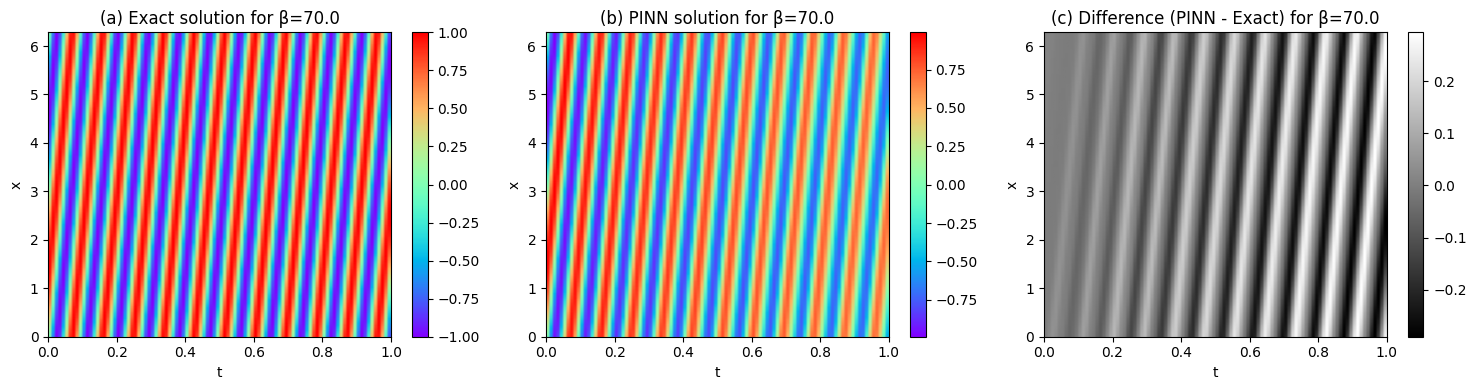

Mean Absolute error:  0.1050288449057471
FOR W_MEAN: 0.9, W_VAR:0.3, W_MAX:0.9


  0%|          | 4/200000 [00:00<2:12:53, 25.08it/s]

Epoch 0: Loss = 110825.453125, PDE Loss = 44175.761719, BC Loss = 1.569124, IC Loss = 6658.692383


 10%|█         | 20013/200000 [04:34<39:42, 75.55it/s]

Epoch 20000: Loss = 2203.302734, PDE Loss = 40.142212, BC Loss = 51.630508, IC Loss = 9.794046


 20%|██        | 40012/200000 [08:53<35:33, 74.98it/s]

Epoch 40000: Loss = 7522.998047, PDE Loss = 4280.408691, BC Loss = 52.455799, IC Loss = 114.435715


 30%|███       | 60010/200000 [13:09<27:11, 85.80it/s]

Epoch 60000: Loss = 1439.434692, PDE Loss = 24.195002, BC Loss = 34.209648, IC Loss = 4.685373


 40%|████      | 80015/200000 [17:12<24:42, 80.92it/s]

Epoch 80000: Loss = 1234.929688, PDE Loss = 20.179554, BC Loss = 29.515610, IC Loss = 3.412567


 50%|█████     | 100010/200000 [21:28<19:33, 85.20it/s]

Epoch 100000: Loss = 1098.702393, PDE Loss = 19.144451, BC Loss = 26.347626, IC Loss = 2.565293


 60%|██████    | 120011/200000 [25:24<15:36, 85.45it/s]

Epoch 120000: Loss = 3877.701172, PDE Loss = 3322.307373, BC Loss = 12.570946, IC Loss = 5.255603


 70%|███████   | 140013/200000 [29:19<11:44, 85.15it/s]

Epoch 140000: Loss = 233.998993, PDE Loss = 10.559138, BC Loss = 5.294450, IC Loss = 1.166186


 80%|████████  | 160014/200000 [33:14<07:48, 85.29it/s]

Epoch 160000: Loss = 128.976486, PDE Loss = 3.091960, BC Loss = 3.050770, IC Loss = 0.385374


 90%|█████████ | 180014/200000 [37:09<03:50, 86.64it/s]

Epoch 180000: Loss = 135.441849, PDE Loss = 7.508303, BC Loss = 3.068494, IC Loss = 0.519379


100%|██████████| 200000/200000 [41:05<00:00, 81.11it/s]


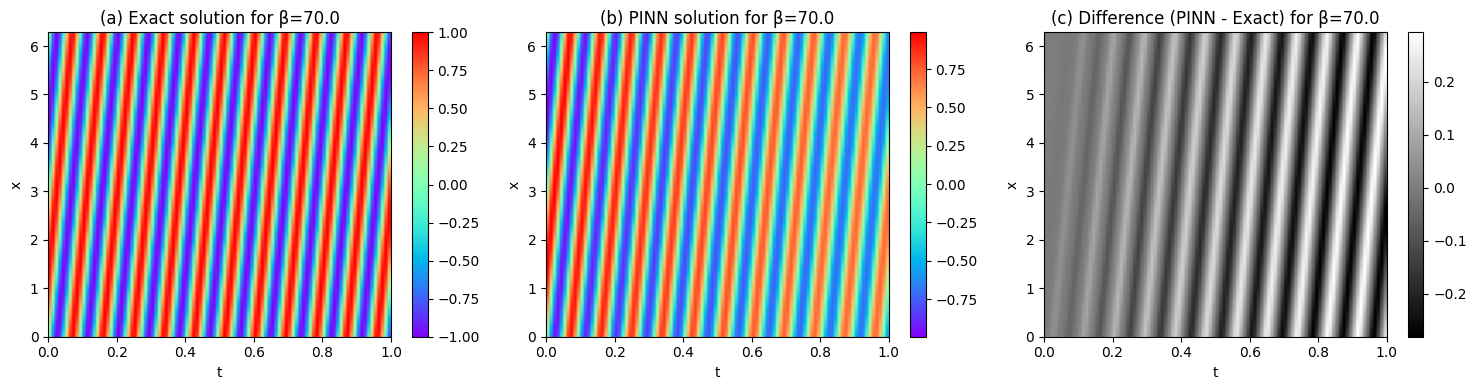

Mean Absolute error:  0.1027330615286001
FOR W_MEAN: 0.9, W_VAR:0.9, W_MAX:0.3


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 287261.875000, PDE Loss = 213886.515625, BC Loss = 52.872429, IC Loss = 7126.044922


 10%|█         | 20017/200000 [03:54<35:10, 85.27it/s]

Epoch 20000: Loss = 2300.785156, PDE Loss = 39.052818, BC Loss = 53.336517, IC Loss = 12.827160


 20%|██        | 40011/200000 [07:46<31:06, 85.74it/s]

Epoch 40000: Loss = 1600.789917, PDE Loss = 27.872662, BC Loss = 37.938904, IC Loss = 5.536109


 30%|███       | 60011/200000 [11:39<26:37, 87.63it/s]

Epoch 60000: Loss = 1280.367188, PDE Loss = 19.127316, BC Loss = 30.573057, IC Loss = 3.831767


 40%|████      | 80016/200000 [15:32<24:20, 82.16it/s]

Epoch 80000: Loss = 1178.043701, PDE Loss = 19.090309, BC Loss = 28.175112, IC Loss = 3.194883


 50%|█████     | 100014/200000 [19:25<19:21, 86.10it/s]

Epoch 100000: Loss = 616.316040, PDE Loss = 19.453493, BC Loss = 14.431595, IC Loss = 1.959874


 60%|██████    | 120010/200000 [23:18<15:39, 85.10it/s]

Epoch 120000: Loss = 324.691071, PDE Loss = 8.075681, BC Loss = 7.626275, IC Loss = 1.156439


 70%|███████   | 140011/200000 [27:11<11:36, 86.17it/s]

Epoch 140000: Loss = 230.548630, PDE Loss = 5.695417, BC Loss = 5.415011, IC Loss = 0.825278


 80%|████████  | 160016/200000 [31:04<08:03, 82.62it/s]

Epoch 160000: Loss = 238.591934, PDE Loss = 16.064312, BC Loss = 5.264062, IC Loss = 1.196512


 90%|█████████ | 180014/200000 [34:58<04:03, 82.11it/s]

Epoch 180000: Loss = 3372.172852, PDE Loss = 2641.178223, BC Loss = 13.484956, IC Loss = 19.159653


100%|██████████| 200000/200000 [38:50<00:00, 85.83it/s]


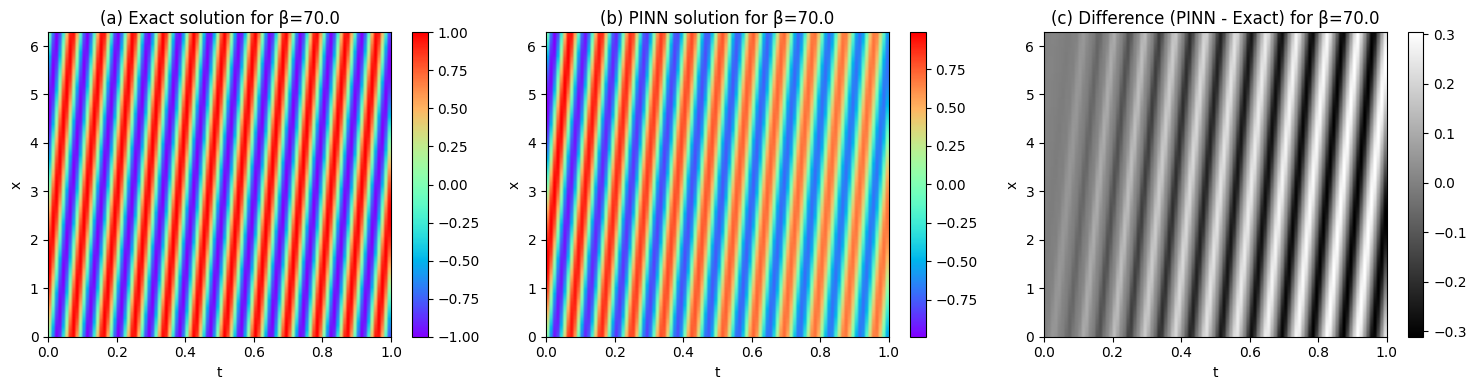

Mean Absolute error:  0.11649380124588024
FOR W_MEAN: 0.9, W_VAR:0.9, W_MAX:0.9


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 244667.156250, PDE Loss = 173413.281250, BC Loss = 43.440556, IC Loss = 6951.625977


 10%|█         | 20009/200000 [03:51<35:07, 85.39it/s]

Epoch 20000: Loss = 3945.090576, PDE Loss = 915.817261, BC Loss = 62.764675, IC Loss = 51.868622


 20%|██        | 40016/200000 [07:44<31:09, 85.58it/s]

Epoch 40000: Loss = 1509.884033, PDE Loss = 32.768589, BC Loss = 35.626823, IC Loss = 5.204250


 30%|███       | 60015/200000 [11:37<27:35, 84.57it/s]

Epoch 60000: Loss = 1278.083496, PDE Loss = 77.444229, BC Loss = 28.853802, IC Loss = 4.648723


 40%|████      | 80018/200000 [15:30<23:11, 86.22it/s]

Epoch 80000: Loss = 803.303406, PDE Loss = 17.048702, BC Loss = 19.081280, IC Loss = 2.300349


 50%|█████     | 100010/200000 [19:24<18:45, 88.81it/s]

Epoch 100000: Loss = 560.494568, PDE Loss = 11.722760, BC Loss = 13.326307, IC Loss = 1.571949


 60%|██████    | 120011/200000 [23:15<15:27, 86.22it/s]

Epoch 120000: Loss = 391.422455, PDE Loss = 8.219333, BC Loss = 9.314158, IC Loss = 1.063677


 70%|███████   | 140010/200000 [27:08<11:53, 84.05it/s]

Epoch 140000: Loss = 303.107056, PDE Loss = 6.387518, BC Loss = 7.205586, IC Loss = 0.849609


 80%|████████  | 160015/200000 [31:02<07:48, 85.27it/s]

Epoch 160000: Loss = 251.177872, PDE Loss = 5.347063, BC Loss = 5.950767, IC Loss = 0.780014


 90%|█████████ | 180010/200000 [34:56<03:55, 84.89it/s]

Epoch 180000: Loss = 182.442337, PDE Loss = 3.968075, BC Loss = 4.336486, IC Loss = 0.501482


100%|██████████| 200000/200000 [38:48<00:00, 85.89it/s]


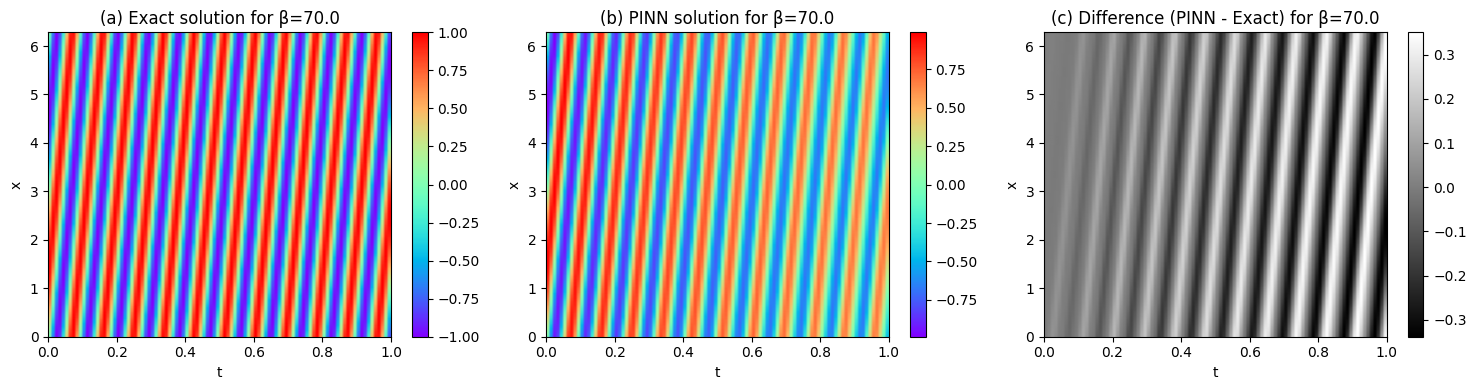

Mean Absolute error:  0.12506275788321278


In [10]:
n_clusters_r = 50
n_clusters_bc = 10
n_clusters_ic = 20
w_mean_arr=[0.3,0.9]
w_var_arr=[0.3, 0.9]
w_max_arr=[0.3, 0.9]

for w_mean in w_mean_arr:
    for w_var in w_var_arr:
        for w_max in w_max_arr:
            print(f"FOR W_MEAN: {w_mean}, W_VAR:{w_var}, W_MAX:{w_max}")
            model = KmeanPINN(input_dim,output_dim,hidden_dim,num_layers,convection_velocity).to(device)
            solver = KMeansPINNSolver(model,n_clusters_r,n_clusters_bc,n_clusters_ic,gamma_r, gamma_bc, gamma_ic, learning_rate, w_mean = w_mean, w_max = w_max,w_var = w_var)
            model,final_loss = solver.train(
                x_r, t_r, 
                x_bc_left, x_bc_right, t_bc, 
                x_ic, t_ic, 
                u_ic_fn, 
                epochs=200000
            )
            visualize(model)
            del model, solver
            torch.cuda.empty_cache()


FOR W_MEAN: 0.9, W_VAR:0.1, W_MAX:0.1


  0%|          | 15/200000 [00:00<46:45, 71.28it/s]

Epoch 0: Loss = 175545.546875, PDE Loss = 112508.179688, BC Loss = 10.696941, IC Loss = 6260.949219


 10%|█         | 20010/200000 [04:22<39:18, 76.33it/s]

Epoch 20000: Loss = 2696.476318, PDE Loss = 688.177124, BC Loss = 46.988575, IC Loss = 12.875616


 20%|██        | 40013/200000 [08:41<34:42, 76.81it/s]

Epoch 40000: Loss = 1512.120728, PDE Loss = 57.487427, BC Loss = 34.861069, IC Loss = 6.019058


 30%|███       | 60010/200000 [13:04<27:05, 86.11it/s]

Epoch 60000: Loss = 4100.736816, PDE Loss = 2663.004883, BC Loss = 31.670246, IC Loss = 17.092205


 40%|████      | 80013/200000 [17:31<28:20, 70.56it/s]

Epoch 80000: Loss = 1202.515381, PDE Loss = 23.547070, BC Loss = 27.823856, IC Loss = 6.601406


 50%|█████     | 100011/200000 [21:48<20:16, 82.18it/s]

Epoch 100000: Loss = 5722.022461, PDE Loss = 4715.144531, BC Loss = 19.693241, IC Loss = 21.914846


 60%|██████    | 120016/200000 [26:05<16:54, 78.88it/s]

Epoch 120000: Loss = 492.912903, PDE Loss = 13.507549, BC Loss = 11.583763, IC Loss = 1.605485


 70%|███████   | 140016/200000 [30:21<12:52, 77.64it/s]

Epoch 140000: Loss = 395.370178, PDE Loss = 69.425644, BC Loss = 7.863197, IC Loss = 1.141663


 80%|████████  | 160012/200000 [34:41<08:40, 76.82it/s]

Epoch 160000: Loss = 295.321655, PDE Loss = 36.421219, BC Loss = 6.222961, IC Loss = 0.998198


 90%|█████████ | 180015/200000 [39:01<04:11, 79.35it/s]

Epoch 180000: Loss = 1700.482422, PDE Loss = 1473.612061, BC Loss = 5.168428, IC Loss = 2.013319


100%|██████████| 200000/200000 [43:19<00:00, 76.93it/s]


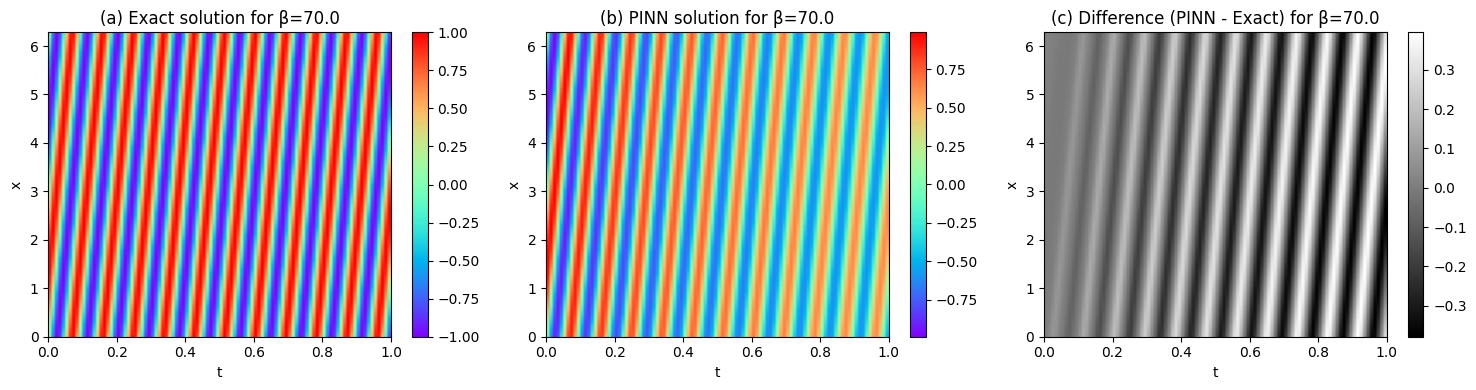

Mean Absolute error:  0.15153713622851456
FOR W_MEAN: 0.9, W_VAR:0.1, W_MAX:0.3


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 153794.125000, PDE Loss = 86064.140625, BC Loss = 10.832144, IC Loss = 6729.669922


 10%|█         | 20009/200000 [04:18<38:04, 78.80it/s]

Epoch 20000: Loss = 2591.559570, PDE Loss = 650.848328, BC Loss = 45.897079, IC Loss = 10.482821


 20%|██        | 40015/200000 [08:39<34:02, 78.34it/s]

Epoch 40000: Loss = 1340.610474, PDE Loss = 31.781923, BC Loss = 31.538170, IC Loss = 4.730164


 30%|███       | 60013/200000 [13:00<29:50, 78.17it/s]

Epoch 60000: Loss = 1348.405640, PDE Loss = 168.547134, BC Loss = 28.100441, IC Loss = 5.584096


 40%|████      | 80016/200000 [17:22<23:07, 86.48it/s]

Epoch 80000: Loss = 759.811462, PDE Loss = 15.894202, BC Loss = 18.055176, IC Loss = 2.171021


 50%|█████     | 100014/200000 [21:12<19:07, 87.16it/s]

Epoch 100000: Loss = 295.353455, PDE Loss = 7.175971, BC Loss = 6.957550, IC Loss = 0.987552


 60%|██████    | 120015/200000 [25:02<15:24, 86.53it/s]

Epoch 120000: Loss = 456.894531, PDE Loss = 205.312195, BC Loss = 5.827350, IC Loss = 1.848834


 70%|███████   | 140014/200000 [28:50<11:03, 90.47it/s]

Epoch 140000: Loss = 164.049759, PDE Loss = 5.713665, BC Loss = 3.828283, IC Loss = 0.520477


 80%|████████  | 160012/200000 [32:45<08:22, 79.62it/s]

Epoch 160000: Loss = 143.974136, PDE Loss = 2.951727, BC Loss = 3.404834, IC Loss = 0.482905


 90%|█████████ | 180012/200000 [37:06<04:12, 79.19it/s]

Epoch 180000: Loss = 105.571808, PDE Loss = 2.030522, BC Loss = 2.508667, IC Loss = 0.319459


100%|██████████| 200000/200000 [41:24<00:00, 80.48it/s]


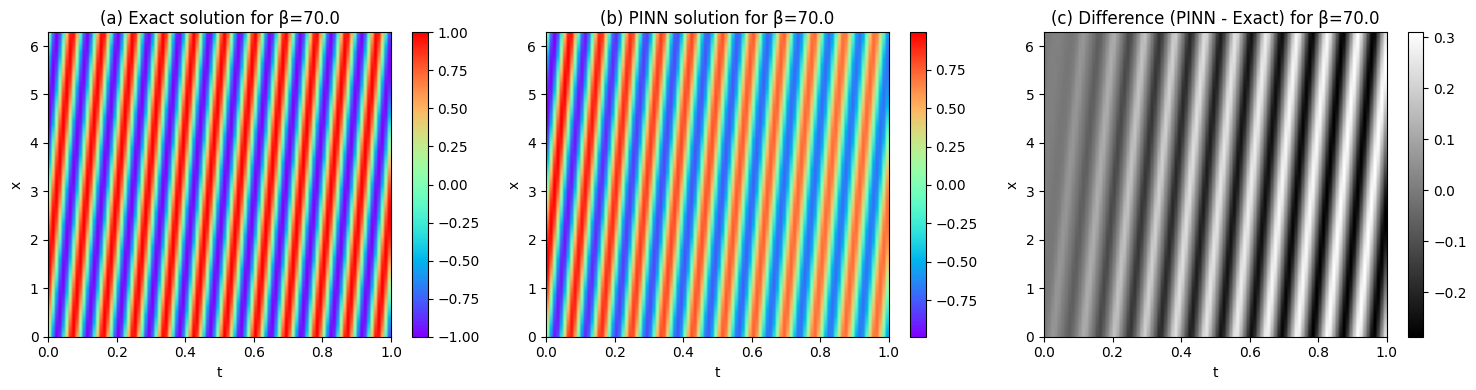

Mean Absolute error:  0.12217317582841031
FOR W_MEAN: 0.9, W_VAR:0.1, W_MAX:0.5


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 181716.906250, PDE Loss = 114273.437500, BC Loss = 30.061106, IC Loss = 6624.102539


 10%|█         | 20010/200000 [04:30<41:02, 73.11it/s]  

Epoch 20000: Loss = 2473.011719, PDE Loss = 46.068501, BC Loss = 57.026604, IC Loss = 14.587893


 20%|██        | 40012/200000 [08:59<39:32, 67.43it/s]

Epoch 40000: Loss = 1517.518555, PDE Loss = 26.376505, BC Loss = 36.003231, IC Loss = 5.101279


 30%|███       | 60011/200000 [13:22<29:13, 79.85it/s]

Epoch 60000: Loss = 1270.547241, PDE Loss = 19.797857, BC Loss = 30.375132, IC Loss = 3.574409


 40%|████      | 80010/200000 [17:48<25:15, 79.20it/s]

Epoch 80000: Loss = 1196.969482, PDE Loss = 144.473663, BC Loss = 25.657015, IC Loss = 2.621517


 50%|█████     | 100010/200000 [22:15<26:07, 63.77it/s]

Epoch 100000: Loss = 352.441895, PDE Loss = 8.637273, BC Loss = 8.322763, IC Loss = 1.089411


 60%|██████    | 120011/200000 [26:41<17:58, 74.15it/s]

Epoch 120000: Loss = 495.235718, PDE Loss = 234.648407, BC Loss = 5.851821, IC Loss = 2.651445


 70%|███████   | 140010/200000 [31:07<12:52, 77.69it/s]

Epoch 140000: Loss = 142.644821, PDE Loss = 3.489049, BC Loss = 3.367186, IC Loss = 0.446836


 80%|████████  | 160014/200000 [35:22<08:55, 74.62it/s]

Epoch 160000: Loss = 550.949036, PDE Loss = 374.428070, BC Loss = 3.767627, IC Loss = 2.581583


 90%|█████████ | 180009/200000 [39:36<04:06, 81.16it/s]

Epoch 180000: Loss = 314.032898, PDE Loss = 133.344193, BC Loss = 4.329541, IC Loss = 0.750707


100%|██████████| 200000/200000 [43:50<00:00, 76.02it/s]


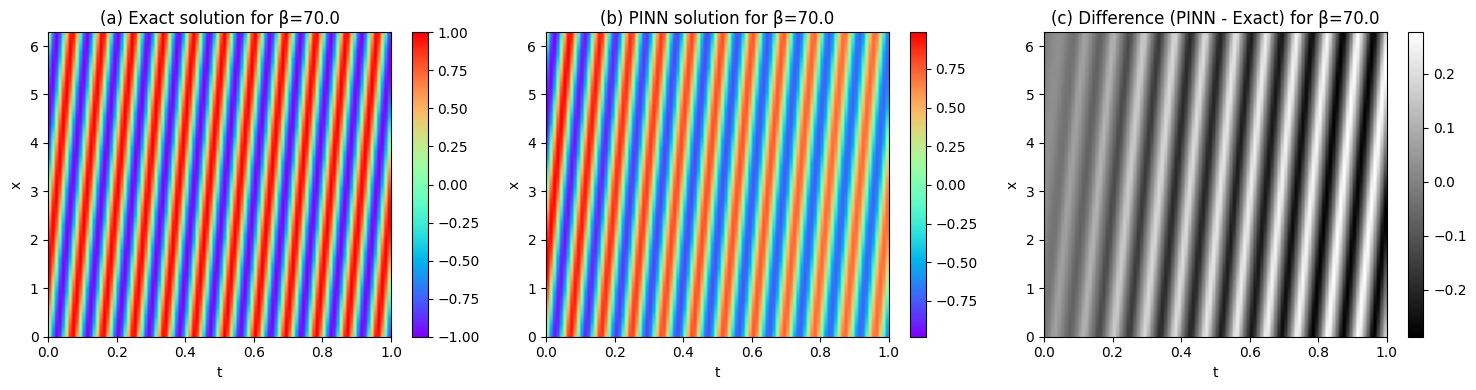

Mean Absolute error:  0.11299181295140613
FOR W_MEAN: 0.9, W_VAR:0.3, W_MAX:0.1


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 371097.625000, PDE Loss = 298044.625000, BC Loss = 51.381454, IC Loss = 7099.774902


 10%|█         | 20009/200000 [04:23<38:13, 78.49it/s]

Epoch 20000: Loss = 2962.385254, PDE Loss = 66.630005, BC Loss = 67.910851, IC Loss = 17.932129


 20%|██        | 40010/200000 [08:40<34:36, 77.04it/s]

Epoch 40000: Loss = 2029.251709, PDE Loss = 43.576492, BC Loss = 47.278423, IC Loss = 9.453817


 30%|███       | 60016/200000 [12:59<29:38, 78.69it/s]

Epoch 60000: Loss = 6321.869141, PDE Loss = 2869.571045, BC Loss = 53.536507, IC Loss = 131.083801


 40%|████      | 80015/200000 [17:17<25:32, 78.30it/s]

Epoch 80000: Loss = 1245.472412, PDE Loss = 19.732080, BC Loss = 29.177696, IC Loss = 5.863238


 50%|█████     | 100014/200000 [21:29<19:10, 86.92it/s]

Epoch 100000: Loss = 712.051636, PDE Loss = 12.794586, BC Loss = 16.945946, IC Loss = 2.141921


 60%|██████    | 120008/200000 [25:23<21:22, 62.39it/s]

Epoch 120000: Loss = 2060.375000, PDE Loss = 1651.075073, BC Loss = 9.624245, IC Loss = 2.433003


 70%|███████   | 140015/200000 [29:24<11:45, 85.05it/s]

Epoch 140000: Loss = 332.978943, PDE Loss = 5.758356, BC Loss = 7.859352, IC Loss = 1.284651


 80%|████████  | 160010/200000 [33:21<07:52, 84.72it/s]

Epoch 160000: Loss = 264.939575, PDE Loss = 4.708795, BC Loss = 6.205416, IC Loss = 1.201414


 90%|█████████ | 180016/200000 [37:20<04:00, 82.96it/s]

Epoch 180000: Loss = 123.367805, PDE Loss = 2.716582, BC Loss = 2.925427, IC Loss = 0.363413


100%|██████████| 200000/200000 [41:17<00:00, 80.72it/s]


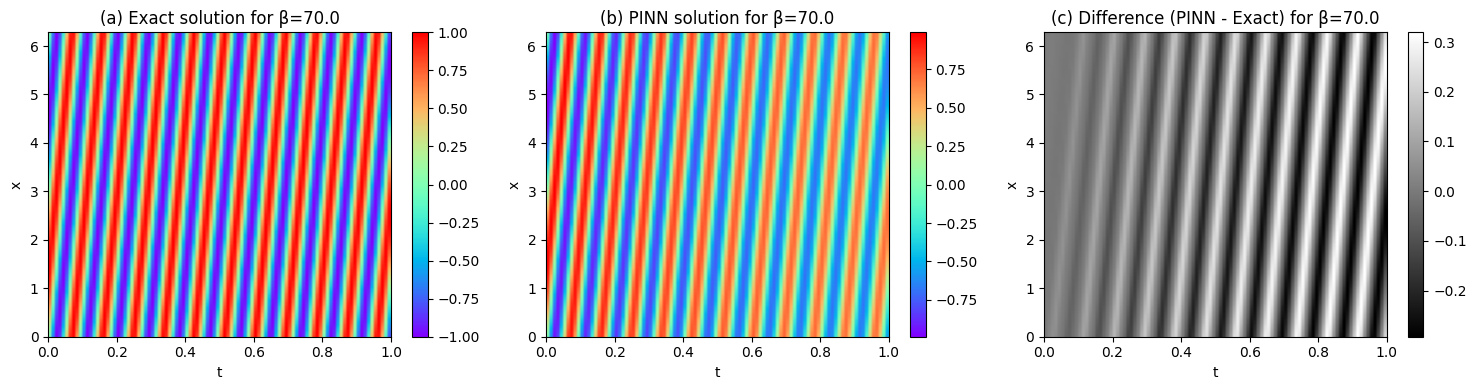

Mean Absolute error:  0.11360668262650676
FOR W_MEAN: 0.9, W_VAR:0.3, W_MAX:0.3


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 532319.750000, PDE Loss = 468005.812500, BC Loss = 80.603363, IC Loss = 6108.978027


 10%|█         | 20010/200000 [03:58<36:46, 81.57it/s]

Epoch 20000: Loss = 2314.239258, PDE Loss = 48.121250, BC Loss = 53.783535, IC Loss = 11.477667


 20%|██        | 40016/200000 [08:12<34:30, 77.27it/s]

Epoch 40000: Loss = 1654.418579, PDE Loss = 31.333328, BC Loss = 38.874294, IC Loss = 6.811337


 30%|███       | 60014/200000 [12:14<28:42, 81.27it/s]

Epoch 60000: Loss = 1293.071045, PDE Loss = 22.980482, BC Loss = 30.828293, IC Loss = 3.695890


 40%|████      | 80017/200000 [16:15<24:15, 82.43it/s]

Epoch 80000: Loss = 1122.697144, PDE Loss = 18.586483, BC Loss = 26.938332, IC Loss = 2.657750


 50%|█████     | 100012/200000 [20:14<21:30, 77.48it/s]

Epoch 100000: Loss = 918.119873, PDE Loss = 19.210262, BC Loss = 21.910578, IC Loss = 2.248652


 60%|██████    | 120012/200000 [24:37<20:06, 66.30it/s]

Epoch 120000: Loss = 350.864197, PDE Loss = 8.143326, BC Loss = 8.262857, IC Loss = 1.220659


 70%|███████   | 140015/200000 [29:12<12:15, 81.52it/s]

Epoch 140000: Loss = 215.760101, PDE Loss = 4.971582, BC Loss = 5.114153, IC Loss = 0.622240


 80%|████████  | 160011/200000 [33:21<08:24, 79.28it/s]

Epoch 160000: Loss = 222.384064, PDE Loss = 7.745369, BC Loss = 5.122570, IC Loss = 0.973590


 90%|█████████ | 180013/200000 [38:02<05:03, 65.88it/s]

Epoch 180000: Loss = 115.260170, PDE Loss = 2.801260, BC Loss = 2.736738, IC Loss = 0.298939


100%|██████████| 200000/200000 [43:02<00:00, 77.46it/s]


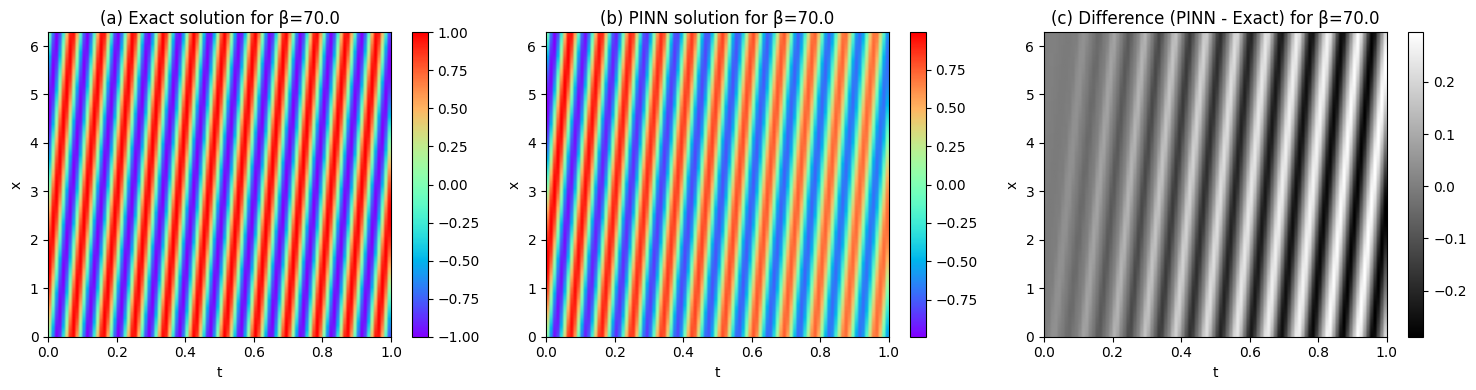

Mean Absolute error:  0.10619036134973082
FOR W_MEAN: 0.9, W_VAR:0.3, W_MAX:0.5


  0%|          | 15/200000 [00:00<45:13, 73.69it/s]

Epoch 0: Loss = 587064.000000, PDE Loss = 520115.218750, BC Loss = 105.461456, IC Loss = 6273.033203


 10%|█         | 20010/200000 [04:15<36:30, 82.15it/s]

Epoch 20000: Loss = 2074.148926, PDE Loss = 38.948616, BC Loss = 48.948387, IC Loss = 7.726486


 20%|██        | 40010/200000 [08:16<32:21, 82.40it/s]

Epoch 40000: Loss = 1652.025635, PDE Loss = 36.383133, BC Loss = 39.160152, IC Loss = 4.923632


 30%|███       | 60010/200000 [12:23<30:20, 76.91it/s]

Epoch 60000: Loss = 1368.700806, PDE Loss = 47.622173, BC Loss = 32.018692, IC Loss = 4.033088


 40%|████      | 80009/200000 [16:59<30:08, 66.36it/s]

Epoch 80000: Loss = 2258.746338, PDE Loss = 1074.583984, BC Loss = 27.218937, IC Loss = 9.540492


 50%|█████     | 100010/200000 [21:21<19:54, 83.74it/s]

Epoch 100000: Loss = 732.982361, PDE Loss = 22.449139, BC Loss = 17.289101, IC Loss = 1.896916


 60%|██████    | 120016/200000 [25:21<15:28, 86.13it/s]

Epoch 120000: Loss = 422.929474, PDE Loss = 24.666365, BC Loss = 9.668143, IC Loss = 1.153737


 70%|███████   | 140013/200000 [29:22<11:48, 84.71it/s]

Epoch 140000: Loss = 325.883514, PDE Loss = 22.954905, BC Loss = 7.298288, IC Loss = 1.099709


 80%|████████  | 160007/200000 [33:51<10:37, 62.78it/s]

Epoch 160000: Loss = 227.040833, PDE Loss = 7.743011, BC Loss = 5.320027, IC Loss = 0.649674


 90%|█████████ | 180007/200000 [39:06<05:20, 62.47it/s]

Epoch 180000: Loss = 170.964417, PDE Loss = 29.163589, BC Loss = 3.253699, IC Loss = 1.165288


100%|██████████| 200000/200000 [43:17<00:00, 77.01it/s]


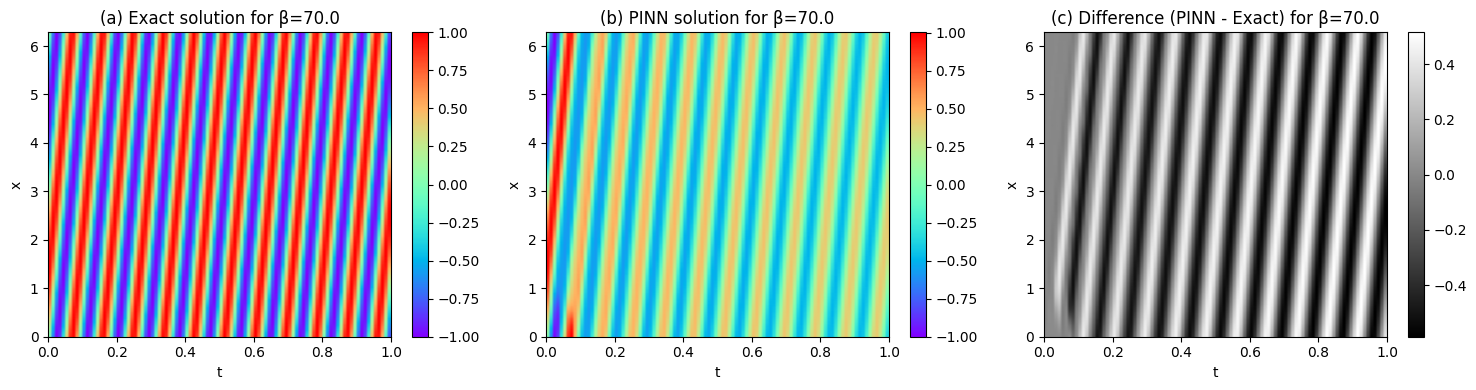

Mean Absolute error:  0.29011012220804827
FOR W_MEAN: 0.9, W_VAR:0.5, W_MAX:0.1


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 290238.250000, PDE Loss = 224000.562500, BC Loss = 17.987837, IC Loss = 6551.818848


 10%|█         | 20009/200000 [04:16<38:19, 78.29it/s]

Epoch 20000: Loss = 5509.758789, PDE Loss = 3313.349365, BC Loss = 49.260361, IC Loss = 22.599495


 20%|██        | 40009/200000 [08:28<32:12, 82.78it/s]

Epoch 40000: Loss = 1552.152588, PDE Loss = 26.816759, BC Loss = 36.949158, IC Loss = 4.736945


 30%|███       | 60012/200000 [12:29<27:25, 85.07it/s]

Epoch 60000: Loss = 1286.139160, PDE Loss = 23.898548, BC Loss = 30.698851, IC Loss = 3.428660


 40%|████      | 80012/200000 [17:01<31:17, 63.92it/s]

Epoch 80000: Loss = 1114.051636, PDE Loss = 19.059027, BC Loss = 26.735786, IC Loss = 2.556111


 50%|█████     | 100010/200000 [21:03<19:59, 83.39it/s]

Epoch 100000: Loss = 1074.853760, PDE Loss = 18.548168, BC Loss = 25.654926, IC Loss = 3.010851


 60%|██████    | 120016/200000 [25:03<15:29, 86.04it/s]

Epoch 120000: Loss = 426.977295, PDE Loss = 8.693125, BC Loss = 10.096003, IC Loss = 1.444408


 70%|███████   | 140014/200000 [28:57<12:06, 82.55it/s]

Epoch 140000: Loss = 223.512009, PDE Loss = 4.647550, BC Loss = 5.316684, IC Loss = 0.619709


 80%|████████  | 160014/200000 [33:01<08:25, 79.06it/s]

Epoch 160000: Loss = 136.204102, PDE Loss = 2.831047, BC Loss = 3.241802, IC Loss = 0.370095


 90%|█████████ | 180013/200000 [37:42<04:38, 71.88it/s]

Epoch 180000: Loss = 110.494705, PDE Loss = 2.405011, BC Loss = 2.630223, IC Loss = 0.288078


100%|██████████| 200000/200000 [42:14<00:00, 78.90it/s]


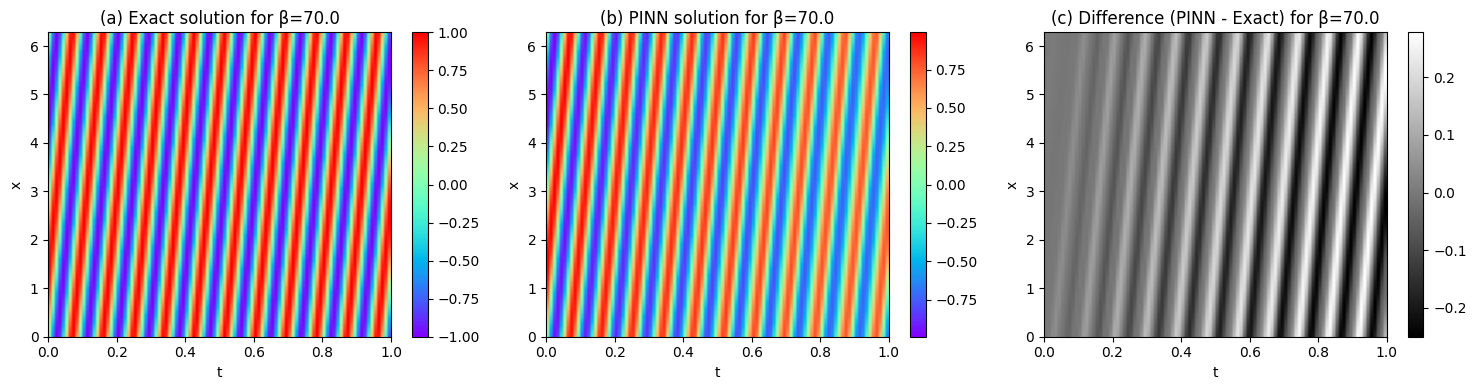

Mean Absolute error:  0.08928584619959298
FOR W_MEAN: 0.9, W_VAR:0.5, W_MAX:0.3


  0%|          | 0/200000 [00:00<?, ?it/s]

Epoch 0: Loss = 1461364.375000, PDE Loss = 1369500.750000, BC Loss = 378.571747, IC Loss = 7672.073242


 10%|█         | 20017/200000 [04:01<36:19, 82.58it/s]

Epoch 20000: Loss = 2335.605957, PDE Loss = 69.073364, BC Loss = 53.691086, IC Loss = 11.888919


 20%|██        | 40010/200000 [07:59<31:28, 84.74it/s]

Epoch 40000: Loss = 4502.879395, PDE Loss = 2702.227051, BC Loss = 38.038677, IC Loss = 27.910496


 30%|███       | 60010/200000 [12:41<30:03, 77.64it/s]

Epoch 60000: Loss = 1324.148560, PDE Loss = 22.272808, BC Loss = 31.371729, IC Loss = 4.700662


 40%|████      | 80017/200000 [16:44<24:14, 82.48it/s]

Epoch 80000: Loss = 1167.208496, PDE Loss = 20.032160, BC Loss = 27.800949, IC Loss = 3.513844


 50%|█████     | 100013/200000 [20:43<19:36, 84.96it/s]

Epoch 100000: Loss = 1035.001709, PDE Loss = 18.568649, BC Loss = 24.668699, IC Loss = 2.968509


 60%|██████    | 120009/200000 [24:40<15:48, 84.33it/s]

Epoch 120000: Loss = 347.309906, PDE Loss = 9.114378, BC Loss = 8.048179, IC Loss = 1.626837


 70%|███████   | 140014/200000 [28:37<11:35, 86.27it/s]

Epoch 140000: Loss = 245.924683, PDE Loss = 25.633844, BC Loss = 5.244891, IC Loss = 1.049517


 80%|████████  | 160013/200000 [33:13<10:29, 63.48it/s]

Epoch 160000: Loss = 206.159546, PDE Loss = 30.023415, BC Loss = 4.179189, IC Loss = 0.896860


 90%|█████████ | 180014/200000 [37:54<04:25, 75.23it/s]

Epoch 180000: Loss = 368.518372, PDE Loss = 203.711777, BC Loss = 3.615324, IC Loss = 2.019366


100%|██████████| 200000/200000 [42:06<00:00, 79.15it/s]


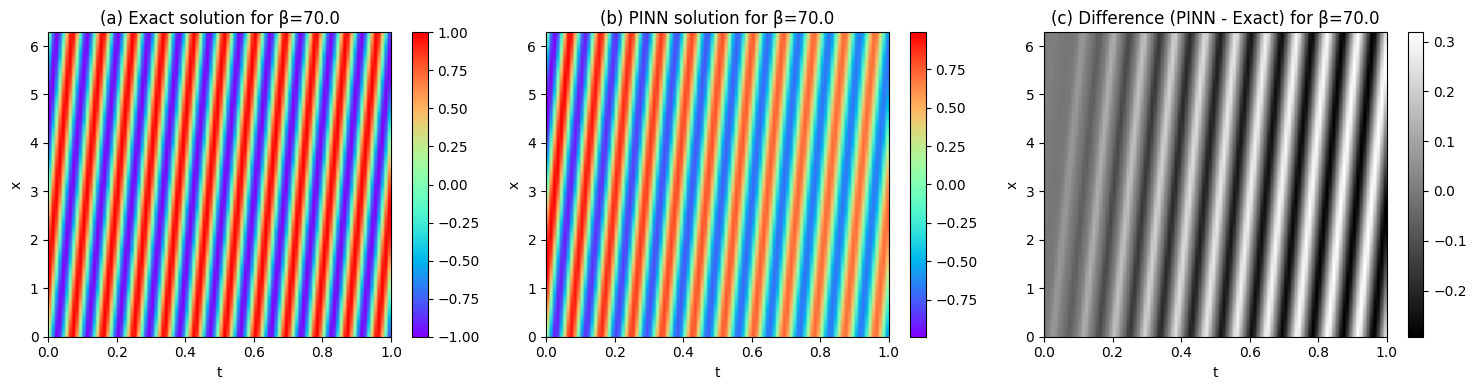

Mean Absolute error:  0.12011371049953494
FOR W_MEAN: 0.9, W_VAR:0.5, W_MAX:0.5


  0%|          | 17/200000 [00:00<41:25, 80.45it/s]

Epoch 0: Loss = 121180.218750, PDE Loss = 51878.539062, BC Loss = 1.046407, IC Loss = 6925.982422


 10%|█         | 20015/200000 [04:14<38:50, 77.23it/s]

Epoch 20000: Loss = 2234.281982, PDE Loss = 43.107765, BC Loss = 50.915482, IC Loss = 15.455501


 20%|██        | 40009/200000 [08:54<43:05, 61.89it/s]

Epoch 40000: Loss = 2161.870850, PDE Loss = 709.771484, BC Loss = 34.227753, IC Loss = 8.298933


 30%|███       | 60009/200000 [13:30<29:22, 79.41it/s]

Epoch 60000: Loss = 1198.019653, PDE Loss = 86.986984, BC Loss = 27.037796, IC Loss = 2.952093


 40%|████      | 80017/200000 [17:36<24:02, 83.17it/s]

Epoch 80000: Loss = 980.577515, PDE Loss = 19.662973, BC Loss = 23.420616, IC Loss = 2.408988


 50%|█████     | 100012/200000 [21:45<21:08, 78.83it/s]

Epoch 100000: Loss = 467.406677, PDE Loss = 90.237152, BC Loss = 8.985194, IC Loss = 1.776176


 60%|██████    | 120013/200000 [26:02<17:25, 76.50it/s]

Epoch 120000: Loss = 293.765228, PDE Loss = 13.836546, BC Loss = 6.701438, IC Loss = 1.187117


 70%|███████   | 140013/200000 [30:19<12:53, 77.58it/s]

Epoch 140000: Loss = 286.394562, PDE Loss = 50.666065, BC Loss = 5.595372, IC Loss = 1.191365


 80%|████████  | 160015/200000 [34:33<08:06, 82.17it/s]

Epoch 160000: Loss = 161.914200, PDE Loss = 3.784864, BC Loss = 3.826162, IC Loss = 0.508285


 90%|█████████ | 180012/200000 [38:38<04:20, 76.75it/s]

Epoch 180000: Loss = 239.275024, PDE Loss = 39.130291, BC Loss = 4.779647, IC Loss = 0.895884


100%|██████████| 200000/200000 [42:55<00:00, 77.64it/s]


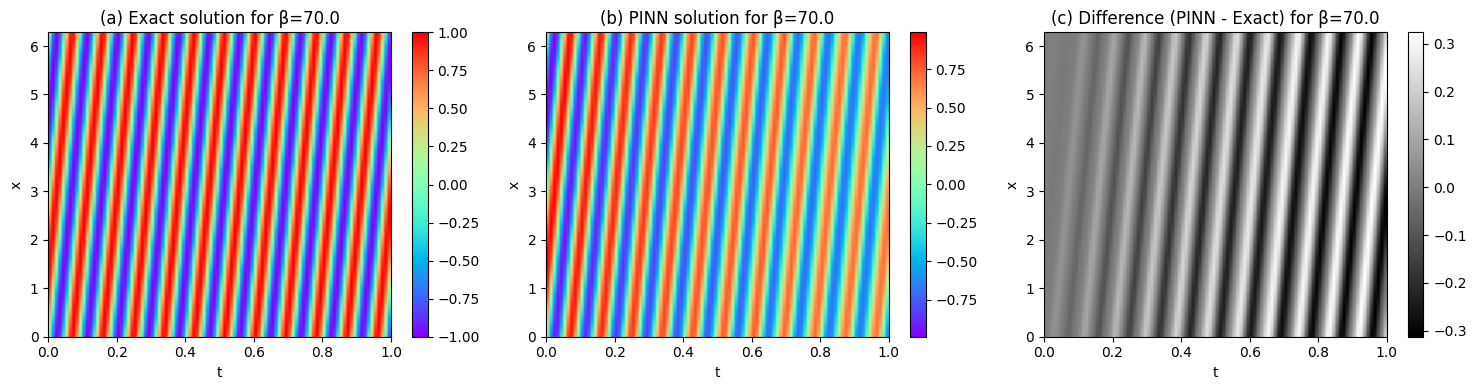

Mean Absolute error:  0.11778601733992834


In [13]:
n_clusters_r = 50
n_clusters_bc = 10
n_clusters_ic = 20
w_mean_arr=[0.9]
w_var_arr=[0.1, 0.3, 0.5]
w_max_arr=[0.1, 0.3, 0.5]

for w_mean in w_mean_arr:
    for w_var in w_var_arr:
        for w_max in w_max_arr:
            print(f"FOR W_MEAN: {w_mean}, W_VAR:{w_var}, W_MAX:{w_max}")
            model = KmeanPINN(input_dim,output_dim,hidden_dim,num_layers,convection_velocity).to(device)
            solver = KMeansPINNSolver(model,n_clusters_r,n_clusters_bc,n_clusters_ic,gamma_r, gamma_bc, gamma_ic, learning_rate, w_mean = w_mean, w_max = w_max,w_var = w_var)
            model,final_loss = solver.train(
                x_r, t_r, 
                x_bc_left, x_bc_right, t_bc, 
                x_ic, t_ic, 
                u_ic_fn, 
                epochs=200000
            )
            visualize(model)
            del model, solver
            torch.cuda.empty_cache()
